# Load data

In [1]:
import torch

import torchvision.transforms as transforms
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.empty_cache()
torch.cuda.synchronize()

train_data_dir = r"../datasets/playing_cards/train"
valid_data_dir = r"../datasets/playing_cards/valid"
test_data_dir = r"../datasets/playing_cards/test"

cuda


In [2]:
from torch.utils.data import DataLoader
from core.dataloaders.playing_cards import PlayingCardDataset

# setting up transformation
transformation = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])
# creating dataset
train_dataset = PlayingCardDataset(
    data_dir=train_data_dir,
    transform=transformation
)
valid_dataset = PlayingCardDataset(
    data_dir=valid_data_dir,
    transform=transformation
)

test_dataset = PlayingCardDataset(
    data_dir=test_data_dir,
    transform=transformation
)

classes = train_dataset.classes
print(classes)

['ace of clubs', 'ace of diamonds', 'ace of hearts', 'ace of spades', 'eight of clubs', 'eight of diamonds', 'eight of hearts', 'eight of spades', 'five of clubs', 'five of diamonds', 'five of hearts', 'five of spades', 'four of clubs', 'four of diamonds', 'four of hearts', 'four of spades', 'jack of clubs', 'jack of diamonds', 'jack of hearts', 'jack of spades', 'joker', 'king of clubs', 'king of diamonds', 'king of hearts', 'king of spades', 'nine of clubs', 'nine of diamonds', 'nine of hearts', 'nine of spades', 'queen of clubs', 'queen of diamonds', 'queen of hearts', 'queen of spades', 'seven of clubs', 'seven of diamonds', 'seven of hearts', 'seven of spades', 'six of clubs', 'six of diamonds', 'six of hearts', 'six of spades', 'ten of clubs', 'ten of diamonds', 'ten of hearts', 'ten of spades', 'three of clubs', 'three of diamonds', 'three of hearts', 'three of spades', 'two of clubs', 'two of diamonds', 'two of hearts', 'two of spades']


training set 7624
valid set 265
test set 265
shapes:
torch.Size([64, 3, 128, 128])
torch.Size([64])


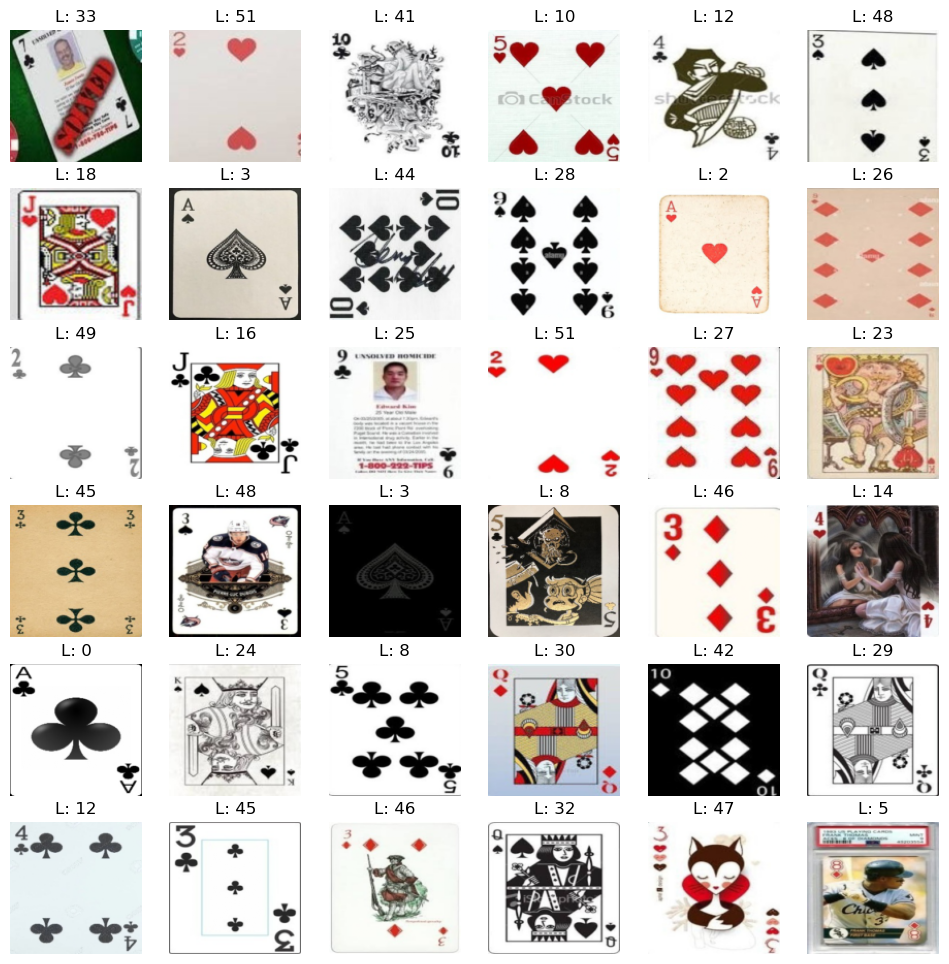

In [3]:
from shared_modules.display_engine import DisplayImages

# creating dataloader
workers = 8
prefetch = workers * 12
train_dataloader = DataLoader(train_dataset,
                              batch_size=32*2,
                              shuffle=True,
                              num_workers=workers,
                              prefetch_factor= prefetch,
                              persistent_workers=True,
                              pin_memory=True)
valid_dataloader = DataLoader(valid_dataset,
                              batch_size=32,
                              shuffle=False,
                              num_workers=workers,
                              prefetch_factor= prefetch,
                              persistent_workers=True,
                              pin_memory=True)
test_dataloader = DataLoader(test_dataset,
                             batch_size=32,
                             shuffle=False,
                             num_workers=workers,
                             prefetch_factor= prefetch,
                             persistent_workers=True,
                             pin_memory=True)

print("training set", len(train_dataloader.dataset))
print("valid set", len(valid_dataloader.dataset))
print("test set", len(test_dataloader.dataset))

# iterating over the dataset
for _, (image, label) in enumerate(train_dataloader):
    print("shapes:")
    print(image.shape)
    print(label.shape)
    DisplayImages.display_image(image, label)
    break

# Model

In [4]:
from core.classifier_models.simplevit import SimpleVitClassifier
model = SimpleVitClassifier(image_size = (3, 128, 128),
                            patch_size = 16,
                            channels = 3,
                            num_classes = 53,
                            depth=4,
                            heads=6,
                            mlp_dim= 256)

In [5]:
# create optimizer and loss function
import torch.nn as nn
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [6]:
# create wrapper
from core.wrappers.wrapper import Wrapper
classifier = Wrapper(model = model, optimizer= optimizer, criterion= criterion, device = "cuda")

In [7]:
from torchinfo import summary
input_size = image.shape
summary(model=classifier.model,
        input_size=input_size,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
SimpleVitClassifier (SimpleVitClassifier)          [64, 3, 128, 128]    [64, 53]             --                   True
├─SimpleViT (base_model)                           [64, 3, 128, 128]    [64, 53]             --                   True
│    └─Sequential (to_patch_embedding)             [64, 3, 128, 128]    [64, 64, 256]        --                   True
│    │    └─Rearrange (0)                          [64, 3, 128, 128]    [64, 64, 768]        --                   --
│    │    └─LayerNorm (1)                          [64, 64, 768]        [64, 64, 768]        1,536                True
│    │    └─Linear (2)                             [64, 64, 768]        [64, 64, 256]        196,864              True
│    │    └─LayerNorm (3)                          [64, 64, 256]        [64, 64, 256]        512                  True
│    └─Transformer (transformer)             

[34, 25, 34, 34, 46, 25, 25, 46, 46, 3, 3, 24, 17, 19, 46, 3, 34, 25, 24, 24, 34, 24, 3, 18, 24, 24, 46, 17, 3, 46, 34, 25, 46, 25, 24, 34, 34, 24, 34, 24, 34, 34, 42, 34, 24, 24, 25, 25, 44, 42, 34, 17, 34, 3, 46, 34, 17, 34, 34, 24, 34, 44, 24, 34, 40, 25, 3, 34, 46, 17, 34, 3, 17, 34, 40, 34, 35, 24, 34, 34, 34, 46, 24, 44, 34, 34, 46, 24, 34, 34, 34, 25, 24, 34, 17, 34, 34, 44, 34, 24, 46, 3, 46, 3, 46, 46, 34, 34, 34, 34, 44, 44, 46, 34, 34, 34, 34, 24, 24, 24, 24, 34, 34, 34, 34, 25, 3, 34, 34, 34, 46, 18, 44, 17, 34, 42, 46, 3, 42, 42, 34, 24, 40, 25, 24, 34, 34, 34, 46, 34, 25, 34, 34, 24, 25, 25, 34, 24, 24, 34, 25, 44, 44, 34, 3, 34, 34, 24, 24, 24, 34, 25, 46, 24, 46, 44, 46, 44, 34, 17, 34, 34, 34, 25, 34, 34, 3, 34, 46, 34, 25, 46, 17, 34, 17, 24, 3, 25, 46, 24, 34, 34, 17, 34, 34, 34, 34, 24, 34, 34, 42, 46, 46, 46, 25, 46, 46, 46, 24, 46, 34, 34, 34, 34, 24, 25, 34, 46, 24, 34, 24, 25, 46, 46, 17, 34, 46, 17, 34, 17, 24, 25, 1, 17, 24, 3, 25, 34, 17, 40, 34, 46, 34, 3, 3

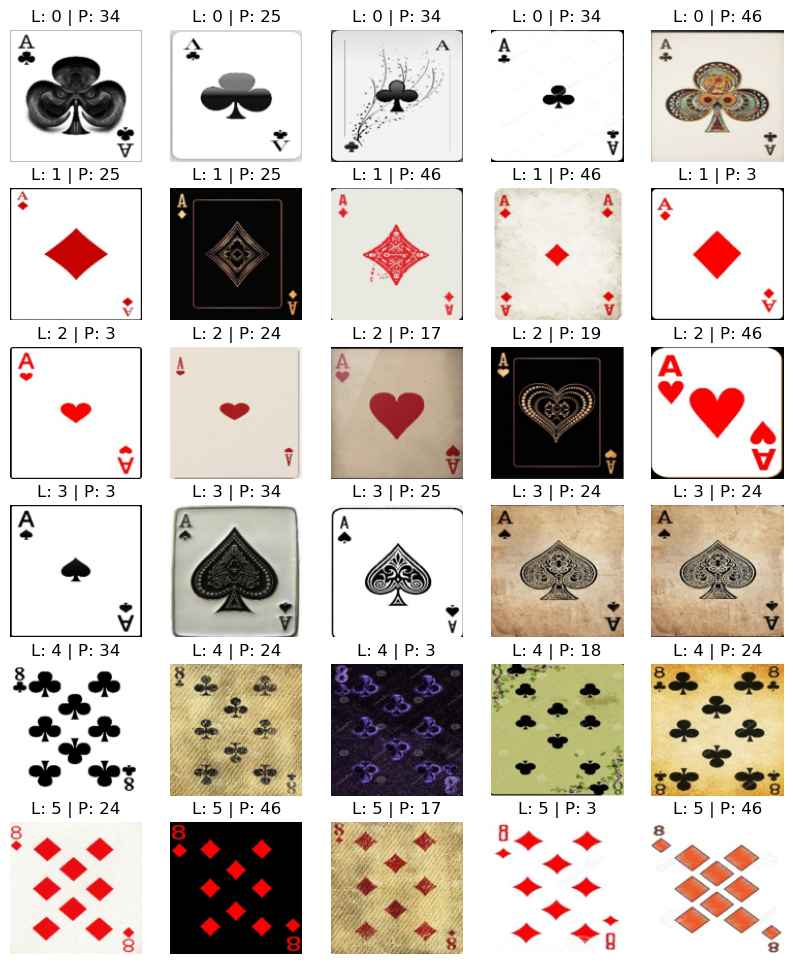

In [8]:
# model accuracy pre training
predictions = classifier.predict_class(test_dataloader)
print(predictions)
loss, acc = classifier.evaluate(test_dataloader)
print(loss, acc)
for _, (image, label) in enumerate(test_dataloader):
    class_pred = classifier.predict_class(image.to(device))
    print(class_pred)
    DisplayImages.display_image(image, label, class_pred, 6, 5)
    break

In [9]:
num_epochs = 30
classifier.fit(epochs=num_epochs, train_dataloader = train_dataloader, valid_dataloader=valid_dataloader)

Epochs::   3%|▎         | 1/30 [00:06<02:55,  6.05s/it]

| Epoch 1/30 | T-loss: 3.824 | V-loss: 3.580 |T-acc: 0.04 |V-acc: 0.06


Epochs::   7%|▋         | 2/30 [00:08<01:45,  3.77s/it]

| Epoch 2/30 | T-loss: 3.441 | V-loss: 3.209 |T-acc: 0.09 |V-acc: 0.11


Epochs::  10%|█         | 3/30 [00:10<01:22,  3.07s/it]

| Epoch 3/30 | T-loss: 3.159 | V-loss: 3.012 |T-acc: 0.14 |V-acc: 0.15


Epochs::  13%|█▎        | 4/30 [00:13<01:15,  2.90s/it]

| Epoch 4/30 | T-loss: 2.926 | V-loss: 2.765 |T-acc: 0.19 |V-acc: 0.17


Epochs::  17%|█▋        | 5/30 [00:15<01:08,  2.72s/it]

| Epoch 5/30 | T-loss: 2.684 | V-loss: 2.544 |T-acc: 0.26 |V-acc: 0.28


Epochs::  20%|██        | 6/30 [00:17<01:01,  2.57s/it]

| Epoch 6/30 | T-loss: 2.461 | V-loss: 2.354 |T-acc: 0.33 |V-acc: 0.31


Epochs::  23%|██▎       | 7/30 [00:20<00:56,  2.46s/it]

| Epoch 7/30 | T-loss: 2.233 | V-loss: 2.207 |T-acc: 0.39 |V-acc: 0.34


Epochs::  27%|██▋       | 8/30 [00:22<00:52,  2.40s/it]

| Epoch 8/30 | T-loss: 2.018 | V-loss: 2.136 |T-acc: 0.46 |V-acc: 0.37


Epochs::  30%|███       | 9/30 [00:24<00:49,  2.36s/it]

| Epoch 9/30 | T-loss: 1.823 | V-loss: 2.050 |T-acc: 0.51 |V-acc: 0.38


Epochs::  33%|███▎      | 10/30 [00:26<00:46,  2.32s/it]

| Epoch 10/30 | T-loss: 1.625 | V-loss: 1.880 |T-acc: 0.57 |V-acc: 0.48


Epochs::  37%|███▋      | 11/30 [00:29<00:43,  2.30s/it]

| Epoch 11/30 | T-loss: 1.429 | V-loss: 1.897 |T-acc: 0.63 |V-acc: 0.46


Epochs::  40%|████      | 12/30 [00:31<00:41,  2.28s/it]

| Epoch 12/30 | T-loss: 1.255 | V-loss: 1.884 |T-acc: 0.68 |V-acc: 0.50


Epochs::  43%|████▎     | 13/30 [00:33<00:38,  2.27s/it]

| Epoch 13/30 | T-loss: 1.101 | V-loss: 1.823 |T-acc: 0.71 |V-acc: 0.51


Epochs::  47%|████▋     | 14/30 [00:35<00:36,  2.26s/it]

| Epoch 14/30 | T-loss: 0.942 | V-loss: 1.774 |T-acc: 0.77 |V-acc: 0.52


Epochs::  50%|█████     | 15/30 [00:37<00:33,  2.25s/it]

| Epoch 15/30 | T-loss: 0.755 | V-loss: 1.840 |T-acc: 0.82 |V-acc: 0.49


Epochs::  53%|█████▎    | 16/30 [00:40<00:31,  2.25s/it]

| Epoch 16/30 | T-loss: 0.640 | V-loss: 1.823 |T-acc: 0.86 |V-acc: 0.54


Epochs::  57%|█████▋    | 17/30 [00:42<00:29,  2.26s/it]

| Epoch 17/30 | T-loss: 0.507 | V-loss: 1.898 |T-acc: 0.90 |V-acc: 0.52


Epochs::  60%|██████    | 18/30 [00:44<00:27,  2.26s/it]

| Epoch 18/30 | T-loss: 0.403 | V-loss: 1.902 |T-acc: 0.93 |V-acc: 0.51


Epochs::  63%|██████▎   | 19/30 [00:47<00:24,  2.25s/it]

| Epoch 19/30 | T-loss: 0.317 | V-loss: 1.841 |T-acc: 0.95 |V-acc: 0.53


Epochs::  67%|██████▋   | 20/30 [00:49<00:22,  2.25s/it]

| Epoch 20/30 | T-loss: 0.227 | V-loss: 1.912 |T-acc: 0.98 |V-acc: 0.54


Epochs::  70%|███████   | 21/30 [00:51<00:20,  2.27s/it]

| Epoch 21/30 | T-loss: 0.172 | V-loss: 1.905 |T-acc: 0.98 |V-acc: 0.58


Epochs::  73%|███████▎  | 22/30 [00:53<00:18,  2.25s/it]

| Epoch 22/30 | T-loss: 0.130 | V-loss: 1.955 |T-acc: 0.99 |V-acc: 0.55


Epochs::  77%|███████▋  | 23/30 [00:56<00:15,  2.25s/it]

| Epoch 23/30 | T-loss: 0.099 | V-loss: 1.987 |T-acc: 1.00 |V-acc: 0.55


Epochs::  80%|████████  | 24/30 [00:58<00:13,  2.24s/it]

| Epoch 24/30 | T-loss: 0.080 | V-loss: 1.957 |T-acc: 1.00 |V-acc: 0.57


Epochs::  83%|████████▎ | 25/30 [01:00<00:11,  2.25s/it]

| Epoch 25/30 | T-loss: 0.057 | V-loss: 1.979 |T-acc: 1.00 |V-acc: 0.57


Epochs::  87%|████████▋ | 26/30 [01:02<00:09,  2.25s/it]

| Epoch 26/30 | T-loss: 0.046 | V-loss: 1.970 |T-acc: 1.00 |V-acc: 0.58


Epochs::  90%|█████████ | 27/30 [01:05<00:06,  2.27s/it]

| Epoch 27/30 | T-loss: 0.037 | V-loss: 2.011 |T-acc: 1.00 |V-acc: 0.56


Epochs::  93%|█████████▎| 28/30 [01:07<00:04,  2.25s/it]

| Epoch 28/30 | T-loss: 0.031 | V-loss: 2.029 |T-acc: 1.00 |V-acc: 0.57


Epochs::  97%|█████████▋| 29/30 [01:09<00:02,  2.29s/it]

| Epoch 29/30 | T-loss: 0.029 | V-loss: 2.063 |T-acc: 1.00 |V-acc: 0.57


Epochs:: 100%|██████████| 30/30 [01:11<00:00,  2.40s/it]

| Epoch 30/30 | T-loss: 0.039 | V-loss: 2.221 |T-acc: 0.99 |V-acc: 0.53


[47, 0, 3, 8, 0, 1, 0, 1, 1, 1, 2, 2, 2, 27, 2, 0, 32, 3, 45, 0, 4, 4, 21, 28, 4, 26, 27, 39, 5, 27, 6, 43, 27, 6, 6, 40, 28, 44, 19, 48, 4, 0, 26, 8, 8, 9, 9, 9, 9, 6, 2, 10, 10, 22, 10, 11, 28, 8, 28, 28, 40, 12, 4, 12, 12, 13, 20, 13, 13, 13, 14, 14, 14, 14, 14, 15, 37, 15, 40, 15, 19, 41, 19, 16, 16, 22, 17, 32, 17, 17, 18, 2, 19, 28, 18, 16, 20, 26, 19, 28, 12, 32, 2, 15, 29, 21, 24, 21, 21, 21, 22, 18, 26, 24, 22, 6, 31, 43, 21, 23, 16, 24, 41, 24, 24, 28, 28, 25, 44, 18, 26, 26, 10, 26, 26, 27, 27, 26, 31, 26, 25, 28, 18, 28, 25, 32, 29, 29, 4, 29, 30, 19, 24, 31, 22, 31, 31, 31, 25, 30, 32, 32, 24, 21, 21, 4, 33, 40, 33, 41, 5, 9, 27, 6, 26, 27, 27, 27, 43, 35, 7, 7, 44, 36, 36, 4, 11, 40, 25, 19, 14, 27, 38, 26, 38, 26, 27, 39, 39, 39, 40, 40, 40, 40, 40, 41, 22, 41, 45, 44, 42, 42, 27, 26, 13, 43, 47, 27, 43, 43, 44, 41, 44, 25, 44, 8, 45, 45, 26, 7, 46, 46, 46, 9, 50, 47, 10, 46, 47, 47, 49, 46, 45, 48, 48, 45, 49, 25, 52, 52, 51, 50, 50, 46, 9, 51, 30, 51, 39, 14, 49, 49, 5

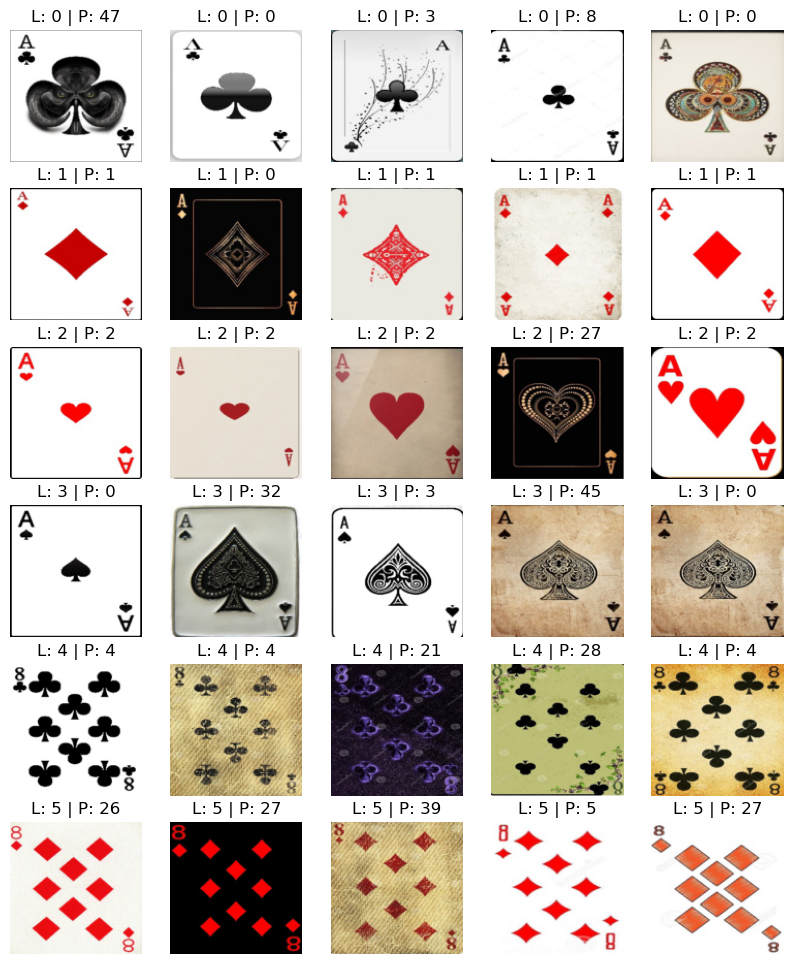

In [10]:
# model accuracy post training
predictions = classifier.predict_class(test_dataloader)
print(predictions)
loss, acc = classifier.evaluate(test_dataloader)
print(loss, acc)
for _, (image, label) in enumerate(test_dataloader):
    class_pred = classifier.predict_class(image.to(device))
    print(class_pred)
    DisplayImages.display_image(image, label, class_pred, 6, 5)
    break

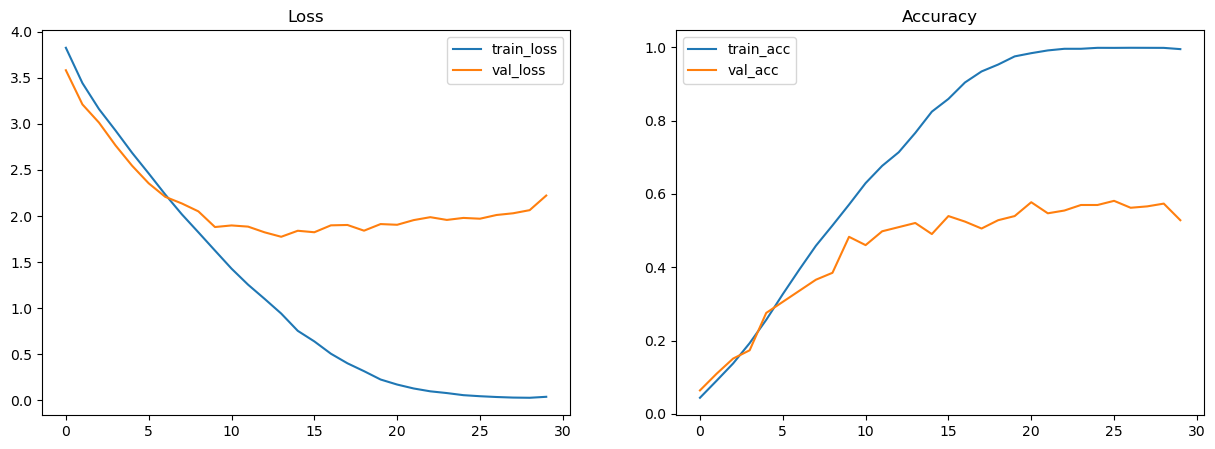

In [11]:
from shared_modules.display_engine import DisplayMetrics

DisplayMetrics.display_metrics(classifier.train_losses,
                               classifier.val_losses,
                               classifier.train_acc,
                               classifier.val_acc)

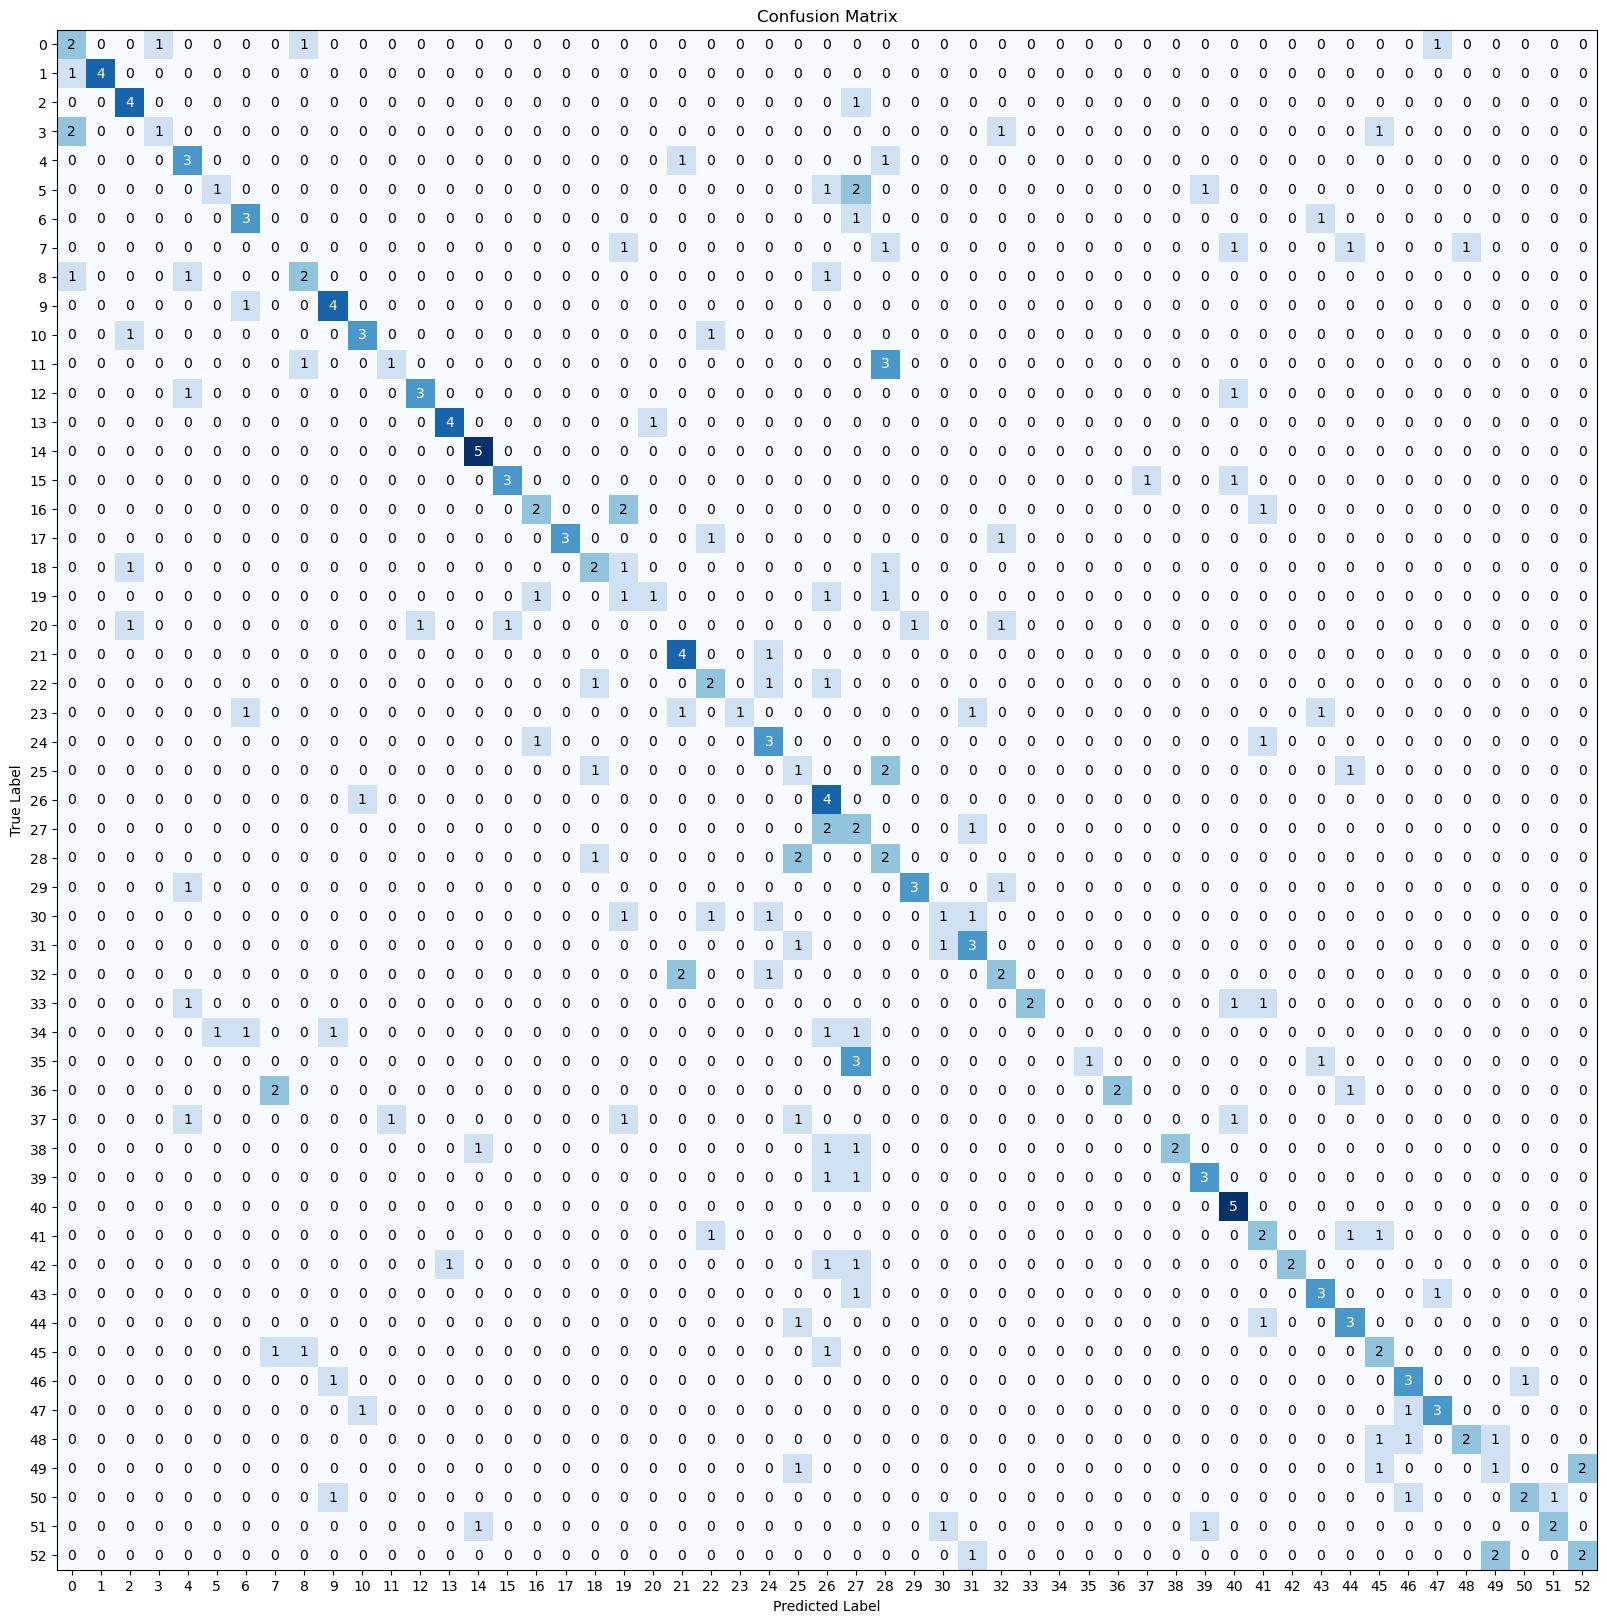

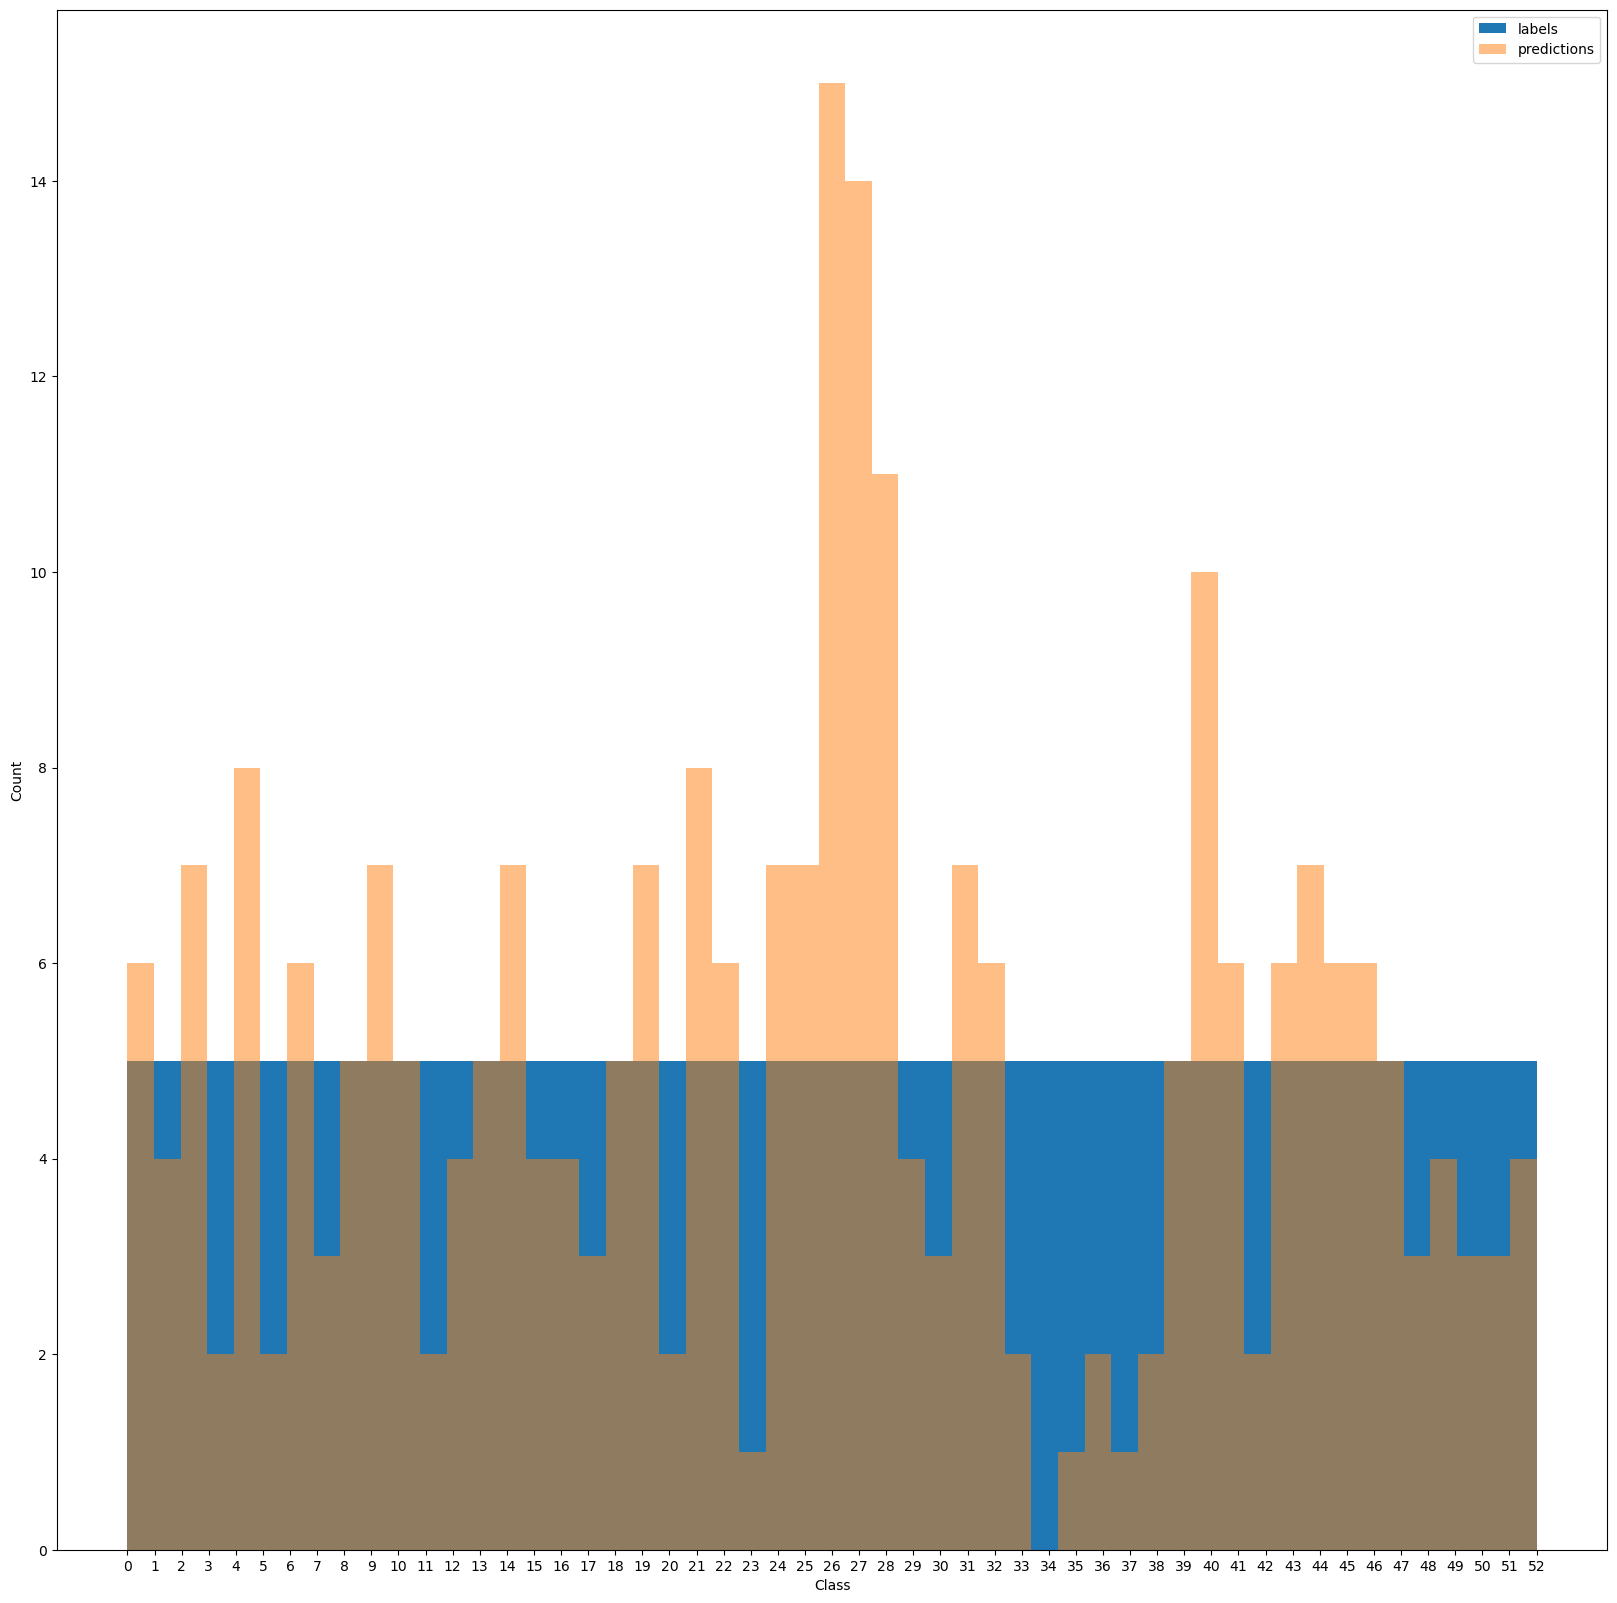

In [12]:
from shared_modules.display_engine import DisplayMetrics

labels = []
class_preds = []
for _, (image, label) in enumerate(test_dataloader):
    class_pred = classifier.predict_class(image.to(device))
    labels.extend(label.numpy())
    class_preds.extend(class_pred)

DisplayMetrics.confusion_matrix(labels, class_preds, (20, 20))
DisplayMetrics.prediction_distribution(labels, class_preds, (20, 20))